# homework 1

in this cell please type your name and the name of anyone you worked with on the homework. 

In [1]:
import matplotlib.pyplot as plt
from collision import *
    
%matplotlib inline

# 2D temperature world

In class we talked about modelling the interaction between an agent and the environment. We looked at a simple 1D case, and learned how we could use object oriented programming to encapsulate the agent and the environment. In the homework we will generalize this to a more complicated, two dimensional environment. But all the basic functions will stay the same!

The basic idea is just a 2-dimensional generalization of what we've already done. There is a 2D temperature grid that an agent moves around in. Same as before the agent has an internal temperature, and it is influenced by the external temperature. Now the agent has the option of eating (using it's internal temperature store) to warm up, or moving to try to find a cooler spot. 

We will talk about more things the agents can do as homework! But first we'll go over the basics of this new setup.

In the code cell below, we first generate the 2D temperature environment. Hotter regions are marked in yellow, and colder are marked in blue. In this first assignment, the temprature grid is stable over time, but varies in space. I hae provided the code to generate the temperature gradient, it is found in the utils.py file. You do not need to modify that function.

<IPython.core.display.Javascript object>


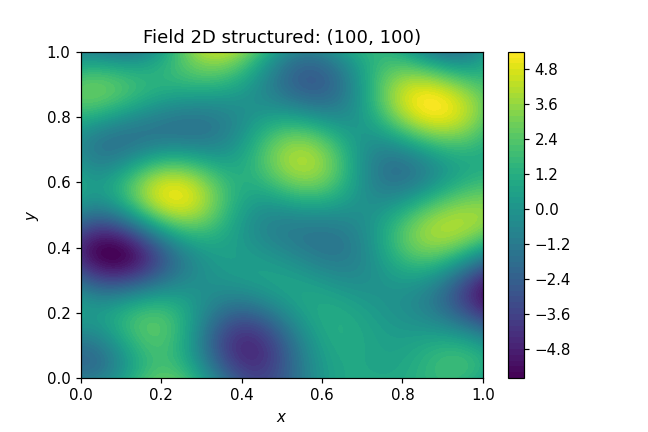

<AxesSubplot:title={'center':'Field 2D structured: (100, 100)'}, xlabel='$x$', ylabel='$y$'>

In [5]:
from utils import generate_tempgrad


srf = generate_tempgrad(.05)

srf.plot()

# 2D agents

There are two main new features we need to add to the existing agent and environment set up. Here we use inheritance to start off with an environment and agent classes with a bunch of basic functionality pre-implemented. That code is found in collision.py, and you do not need to modify it. Primarily it deals with animations, and setting up multiagent environments that are only used in the extra credit questions.

First, we define a particle class with a number of instance properities. Particles have positions (self.r = x, y), velocities (self.v = (vx, vy)), physical parameters like mass and radius (which only impact how they bounce off walls, and what the simulation looks like), they have an internal food store, they have a temperature set point, they have an initial temperature, they have a margin, and they have logs. Just like we did in class!

We define a monitor function, an exist function, and an advance function, just like before. We add a move function, which changes the particles position according to it's velocity, and a consume function, which decreases the food store and increases the internal temperature. 

For the environment: we need to modify the way the environment interacts with the agent. We implement 3 types of interactions. First, the environment bounces the agent off the walls, if it collides with the walls (this is code is located in collision.py if you are curious). Next, we need to update the temperature of the agent to move in the direction of the temperature grid at it's current location. Finally, we need to update the velocity of the agent depending on how how the current region is. 

We also define an advance function for the environment where it iterates through a list of agents then advances them one by one. It's not critical that you understand this section, unless you want to try the extra credit!|

In [6]:
#inherits a simulation superclass that deals with animations etc.
#now lets define the code for the environment and the agent! 
#particles have a position and velocity, a temperature, some energy, and other parameters for plotting
class newParticle(Particle):
    """A class representing a two-dimensional particle."""
    def __init__(self, x = .5, y = .5, vx = 1.1, vy=1.1, radius = .05, styles = {'edgecolor': 'r', 'linewidth': 2, 'alpha': .5} , food_store = 100):
        self.r = np.array((x, y)).astype('float32')
        self.v = np.array((vx, vy)).astype('float32')
        self.radius = radius
        self.mass = self.radius**2
        self.delete = False
        self.styles = styles
        if not self.styles:
            # Default circle styles
            self.styles = {'edgecolor': 'c', 'fill': False}
        self.food_store = food_store
        self.temperature = 98; 
        self.set_point = 98 #homeostatic temp
        self.margin = 2
        
        self.temp_log = []
        self.food_log = []
    
    def monitor(self):
        return self.temperature - self.set_point
    
    def consume(self, dt):
    
        self.food_store -= 1;

        self.temperature += .1
         
    def move(self, dt, boost = 10):
    
        boost = np.random.uniform(-1, 1, size = 2)*boost
        self.v += boost 
        self.r += self.v * dt

        
    def exist(self, dt):
        #we slow down
        self.v = .95*self.v
        
        self.move(dt, boost = 0)
        self.temp_log.append(self.temperature)
        self.food_log.append(self.food_store)
        
        #this means we're dead!
        if self.food_store < 0:
            self.delete = True
        if self.temperature < 85 or self.temperature > 105:
            self.delete = True
            
    def advance(self, dt):
        """Advance the Particle's position forward in time by dt."""
        
        #do basic functions
        self.exist(dt)
        #check internal state
        d_temp = self.monitor()
        
        if d_temp < self.margin:
            self.consume(dt) 
        elif d_temp > self.margin:
            #nothing particle friend can do but move and hope life gets better
            self.move(dt, boost = .5)
            
            
            
class twoD_environment(Simulation):
    #this is our interaction! The environment changes temperature and motion of the particle
    
    def interact(self, p):
            #bounce the particle off the walls
            self.handle_boundary_collisions(p)
            
            #change the temperature of the agent
            x_ind, y_ind = self.get_grid_inds(p)
            p.temperature = p.temperature + self.srf.field[x_ind, y_ind]*(self.dt) #add the velocity v
            
            #move faster in high temp regions
            if self.srf.field[x_ind, y_ind] > 0:
                p.v = p.v + .075*self.srf.field[x_ind, y_ind]*self.dt
            if self.srf.field[x_ind, y_ind] < 0:
                p.v = p.v + .01*self.srf.field[x_ind, y_ind]*self.dt    
                
    def advance(self):
        """Advance the animation by dt."""
        for i, p in enumerate(self.particles):
            if p.delete:
                self.particles.remove(p)
                self.n -=1
            else:
                p.advance(self.dt)
                self.interact(p)
        
        self.handle_collisions()
                

            

I have set up code that allows us to watch an animation of the particle interacting with the environment. Run the code below to see how this works!

<IPython.core.display.Javascript object>


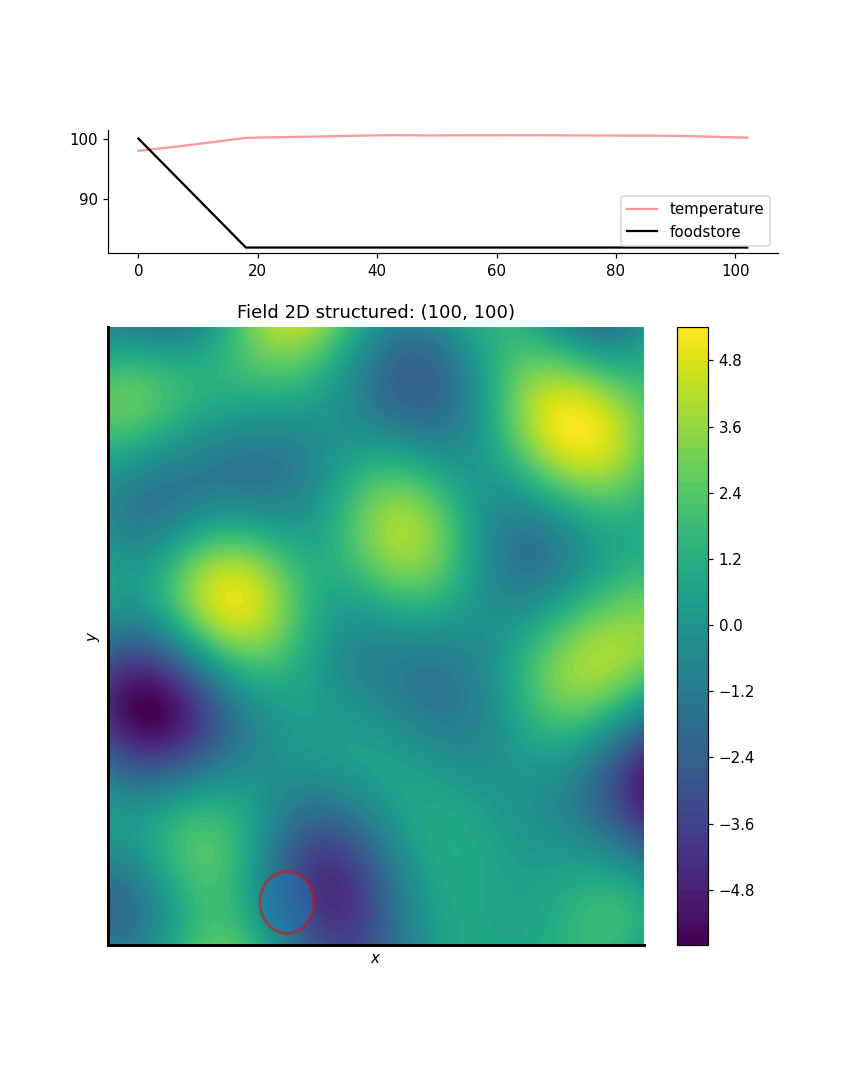

In [11]:
%matplotlib notebook

nparticles = 0

#define the plotting details
styles = {'edgecolor': 'c', 'linewidth': 1, 'fill': 'c', 'alpha' : 1}


#create a new environemnt
sim = twoD_environment(nparticles, [], styles, srf)
#create a particle
p = newParticle()

#add the particle to the environment
sim.particles.insert(0, p)


anim = sim.do_animation(save=False)

# Despite being bigger, set the mass of the large particle to be the same
# as the small ones so it gains a bit of momentum in the collisions

But we can also interact with the advance functions of the agent in a loop, the same as we did in class. This lets us run many simulations more quickly, and then find out our average lifetime. It should take a few minutes for the below code to run.

In [16]:
life_times = []

for i in range(100):
    sim = twoD_environment(nparticles, [], styles, srf)
    p = newParticle()
    #add our particle to the simulation
    
    sim.particles.insert(0, p)


    i = 0;
    while len(sim.particles) > 0: #the environment automatically removes the particle when it dies
        sim.advance()
        i+=1;
        
    life_times.append(i*sim.dt)

<IPython.core.display.Javascript object>


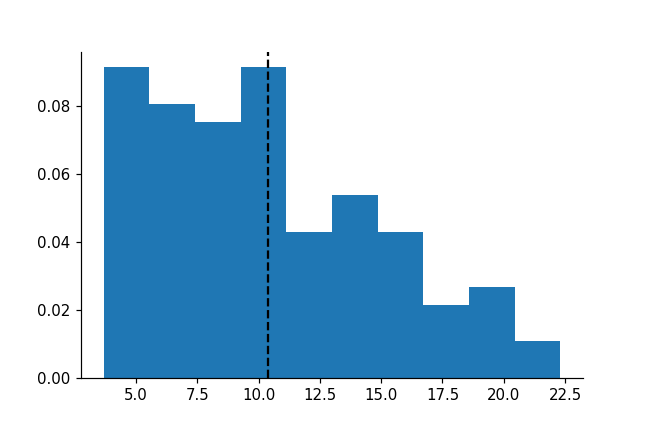

Text(10.4, 0.015, 'the average lifetime is :10.4')

In [17]:
plt.hist(life_times, density = True)
sns.despine()
plt.axvline(np.mean(life_times), color = 'k', linestyle = '--')
plt.annotate("the average lifetime is :" + str(np.mean(life_times).round(2)), [str(np.mean(life_times).round(2)), .015])

# Homework Question 1 (4 pts)

In the below cell we generate environments with different levels of spatial variation.

Your task is to modify the code for testing average lifetimes to test how lifetimes vary as a function of spatial variation in the output. You do not need to modify the code which generates the environment!


>Question A (2pts): You should run a simulation to determine the particles average lifetime in each of the below environments

>Question B (1pt): You should plot the histogram of lifetimes in your simulation, separately for each environment. 

>Question C (1pt) : You should then create another plot which shows how the lifetime length depends on environment complexity. This will be one plot with the y axis = "environment complexity" and the x axis = "lifetime". Your plot should have error bars generated from your simulation. Then write a few sentences discussing your results

C:\Users\Amy\anaconda3\envs\gstools\lib\site-packages\gstools\field\plot.py:368: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<AxesSubplot:title={'center':'Field 2D structured: (100, 100)'}, xlabel='$x$', ylabel='$y$'>,
 <AxesSubplot:title={'center':'Field 2D structured: (100, 100)'}, xlabel='$x$', ylabel='$y$'>,
 <AxesSubplot:title={'center':'Field 2D structured: (100, 100)'}, xlabel='$x$', ylabel='$y$'>,
 <AxesSubplot:title={'center':'Field 2D structured: (100, 100)'}, xlabel='$x$', ylabel='$y$'>)

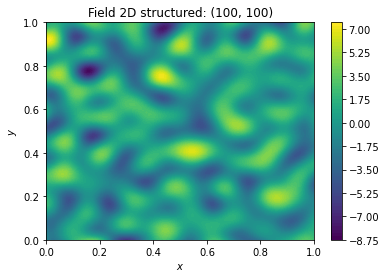

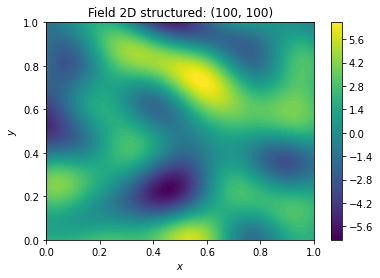

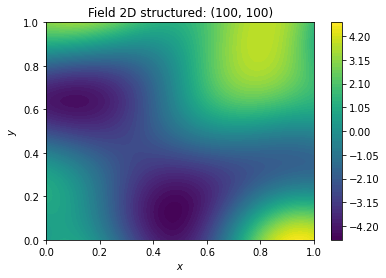

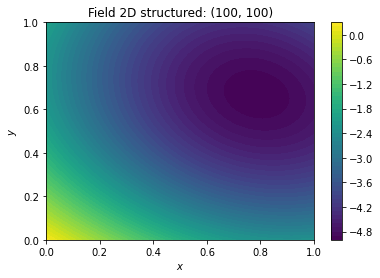

In [21]:
#generate 4 environments with different spatial scales of variation
%matplotlib inline
srf1=generate_tempgrad(.02)
srf2=generate_tempgrad(.05)
srf3=generate_tempgrad(.1)
srf4=generate_tempgrad(.4)
srf1.plot(), srf2.plot(), srf3.plot(), srf4.plot()

>A) Use the cell below to test the average lifetime! Hint: you can do this with a single embedded for-loop (e.g. an outer loop for environments, and an inner loop for running the simulation. 

In [ ]:
#write your code to test the average lifetime as a function of environmental variation here



> B) Now, plot the life-time histograms for each simulation! Remember to label your axes!

In [ ]:
%matplotlib inline

#write your code to generate the histograms here

> C) Now make a plot demonstrating how mean lifetime varies with environment complexity!

In [22]:
#write you code to generate the plot here! Hint: https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html

> Finally, write a few sentences commenting on any patterns you see, and any ideas you might have about why those patterns emerge. 

write a few sentences here!

# Homework Question 2 (6 points)

Now we will modify the simulation to try to make the lifetime longer!! Please use the original environment complexity of .05 to complete this question. 

We inherit the newParticle class, and only override the advance function.

Rules: 
1) you can't alter the particles temperature directly.

2) you can't change the default constructer arguments

3) you can't add new state variables.

4) you *can* change the logic of when the particle moves, and when it eats food 
turn in your code in this cell, and a plot showing the lifetime of your particle! 

>A. (2 pts)
But first, we add one piece of complexity to the simulation. Please modify the below code so that it "costs" "boost" amount of food to move per unit time (dt*boost)! That is, we use up energy by moving. To be precise, you should subtract boost*dt from the existing food store, in the move function

In [25]:
class hwParticle(newParticle):
    """A class representing a two-dimensional particle."""
    def __init__(self):
        super().__init__()
        
    def move(self, dt, boost = 1):
        
        #insert your code here to "charge" the agent one unit of food per unit of boost.
        
        self.food_store = #your code here
        
        #
        
        boost = np.random.uniform(-1, 1, size = 2)*boost
        self.v += boost 
        self.r += self.v * dt

            
    def advance(self, dt):
        """Advance the Particle's position forward in time by dt."""
        
        #do basic functions
        self.exist(dt)
        #check internal state
        d_temp = self.monitor()
        
        if d_temp < self.margin:
            self.consume(dt) 
        elif d_temp > self.margin:
            #nothing particle friend can do but move and hope life gets better
            self.move(dt, boost = .5)


<IPython.core.display.Javascript object>


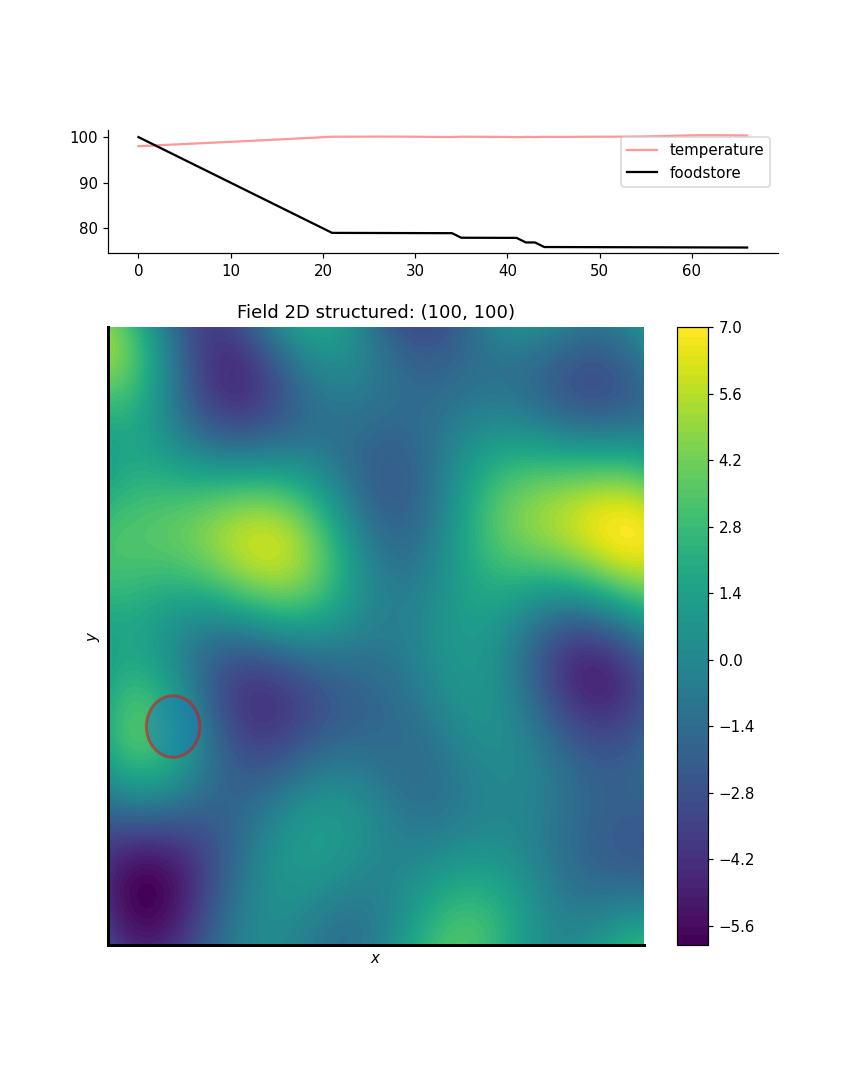

In [26]:
%matplotlib notebook

nparticles = 0

srf = generate_tempgrad(.05)

sim = twoD_environment(nparticles, [], srf = srf)
p = hwParticle()

sim.particles.insert(0, p)


anim = sim.do_animation(save=False)

> B. (1 pt) Comment on how the change qualitatively changes the agents performance, if you noticed any differences

your comments go here

> C. (1pt) Now run the code to simulate 100 lifetimes, and plot the results. How does the performance change quantitatively?

In [ ]:
#simulation code


In [ ]:
%matplotlib inline
#plotting code


your comments go here

> D. (2 pts) Particle friend didnt do very well! Can you change the "advance" function of the hwParticle class, to try to help out the particle?

In [ ]:
#copy and paste your definition of the HW particle class here, then modify the "advance" function to help the particle live longer.

In [ ]:
#run the simulation (100 times)

In [ ]:
#plot the average lifespan histogram. Were you able to make any improvement? 

your comments here

# Extra credit (max: 5pts)

The last part of this assignment is open ended for those who want to dig deeper into the code!

option 1: simulate multiple particles at once! You might have notice that we add our particle to the simulation by calling sim.Particles.insert(0, p) -- that means we are inserting our agent-particle into the beginning of a list of particles. But our simulation can actually support running multple particles at once, even from different classes. Add multiple particles to the simulation and comment on it's behavior! You should include your code to insert the particles below, some plots to quantify things, and a few sentences discussing your changes and the results. 

option 2: evolve your agent! We have been running an outer loop to quantify how long our agents live, but we could also chhange parameters like the initial velocity, the margin, and the default amount of movement (found in the particle.exist() function). Write an outer loop to implement evolution of a parameter of your chosing in the particle. Include the code for your changes and write a few sentences discussing them, and how they differ from actual evolution, below.